There are two ways of attacking this problem. We could either do a random simulation, or we could do systematic counting. Let's consider random simulation:

* Initialize variables: number of simulations $M$, number of points per interval (density of points) $D$, length of interval $L$.
* Create a zero vectors of length M: `iVec` (will contain indices of left-hand and right-hand endpoints in $I \cup S$). The vector should be of type uint64 (unsigned 64-bit integer).
* Generate a vector `ptVec` containing $N=D(L+1)$ random points in $[0,L+1]$. Sort the vector in increasing order.
* Loop over trials: mm = 0 to M-1
   - Generate a random point in $[0,L]$.  This is the left-hand endpoint, which we will call $x$.
   - Find the _indices_ of the smallest and largest points in $[x,x+1] \cup S$. For speed, use bisection search: https://docs.python.org/2/library/bisect.html.  Store ( (_index_ of the smallest point)*$N$ + _index_ of largest point) in the vector `iVec` 
* Sort the entries of `iVec`. Identify the number of distinct (unique) entries. Call this value `U`. This is the number of distinct sets of the form $I \cap S$.

_Histogram for set probabilities_

* Create a vector containing the unique values in iVec.  You may use the function `numpy.unique`.  Call this vector `uVec`. Note that `uVec` will have length `U` (as defined above).

* Create a vector `setCount` of length `U`, such that `setCount[j]` is the number of times that the `j`'th value in `uVec` appears in `iVec`. You can do this by looping through the entries of uVec.

* Create a histogram for the values of `setCount`.  This is the probability distribution on the number of times each distinct set is chosen. 

_The following points will enable the counting of distinct maximal sets of the form $I \cap S$:_

* Compute `lVec` as  `iVec//N` and `rVec` as `iVec%N`. These are the left-most and rightmost points in $S$ lying in each interval. Note that`lVec` will be sorted; and for each individual value of `lVec`, `rVec` is sorted.

* Define a logical vector `mVec` of length `M-1` such that `mVec[j]=0` if `lVec[j]=lVec[j+1]` and `mVec[j]=1` otherwise. (You can do this with a loop if you want, but there's a faster way.)  Note that  if `mVec[j]=1` then `rVec[j]` is the largest possible rightmost point in a vector that has `lVec[j]` as a leftmost point.   

* Define `lmVec = lVec[mVec]` and `rmVec = rVec[mVec]`.  In this list, for any leftmost point `lmVec[j]`, the value of `rmVec[j]` is the largest possible rightmost point for intervals with that leftmost value. Note that each point in $S \cap [0,L]$ should appear exactly once in this list. (You may use this fact to check your code.) `lmVec` and `rmVec` will have the same length, which you can call `Ul`.

* Define a logical vector `MVec` of length `Ul` such that `MVec[0]=1` if `rmVec[j]`$\neq$`rmVec[j-1]` and `MVec[j]=1` otherwise. (You can do this with a loop if you want, but there's a faster way.)  Note that  if `MVec[j]=1` then `lmVec[j]` is the leftmost possible lefttmost point in a vector that has `rmVec[j]` as a rightmost point. Since the left-right endpoint combinations in `lmVec` and `rmVec` already have maximal right endpoint for each given left endpoint, it follows that `lmVec[MVec]` and `rmVec[MVec]` contain the leftmost and rightmost points for maximal sets of the form $I \cap S$.

* Set `nMax` equal to the number of nonzero entries in `MVec`.  This is the number of maximal  sets of the form $I \cap S$. 

* We may ask the question, are maximal sets more or less likely than others to appear? To answer this question, we may make a histogram for the number of times maximal intervals are chosen. Form the vector `N*lmVec[MVec]+rmVec[MVec]`.  These are the values in `iVec` that correspond to maximal sets. Loop through these values and count the number of times they each appear in `iVec`. Make a histogram of the results.



The number of different possible sets of intersections is  987



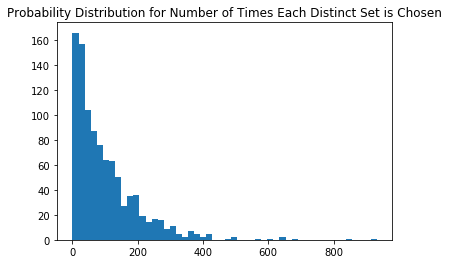

The number of maximal sets is  246


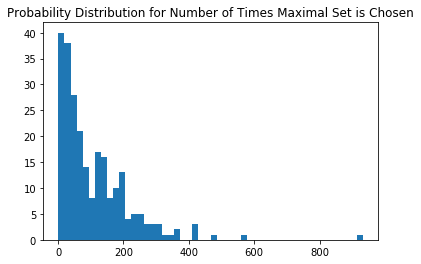

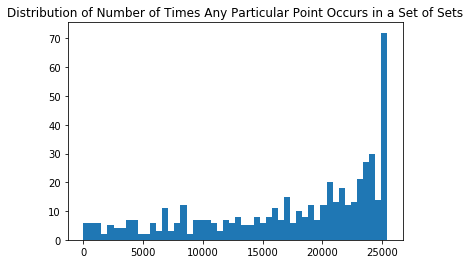

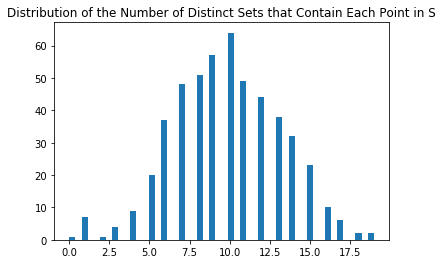

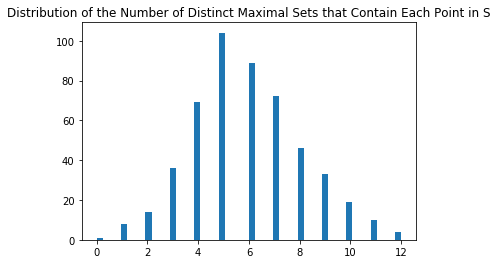

In [2]:
import numpy as U
import bisect as B
%matplotlib inline
import matplotlib.pyplot as P

L = 100              #length of interval
D = 5                #number of points per interval - DENSITY
M = 100000           #number of simulations done
N = U.int(D*(L + 1)) #number of points TOTAL - make sure it's an integer!!

iVec = U.zeros(M, dtype=U.uint64)                  #create vector size M for 1st,last indices of sets intersecting S
ptVec = U.sort(U.random.uniform(0,L+1,N))          #create sorted vector of N number of random points on [0,L+1]

def find_ge(a, x):  #'Function to find leftmost value greater than or equal to x'
    i = B.bisect_left(a, x)
    if i != len(a):
        final = i
    else: 
        final = 1
    return final
    
def find_le(a, x):  #'Function to find rightmost value less than or equal to x'
    i = B.bisect_right(a, x)
    if i:
        final = i-1
    else: 
        final = 1
    return final

##Perform random simulation to get intersecting sets:
for mm in range(0, M):
    x = U.random.uniform(0,L)   #generate a random floating point between 0 and L
    i = find_ge(ptVec, x)       #find index of leftmost point in [0,L]
    j = find_le(ptVec, x+1)     #find index of rightmost point in [0,L]
    iVec[mm] = i*N + j          #put indices in "trick" formula so they can be extracted as needed later
    if x < ptVec[i] and ptVec[i] <= ptVec[j] and ptVec[j] < x+1:
        iVec[mm] = iVec[mm]     #assign the values for all valid entries
    else:
        iVec[mm] = -1           #assign negative values for invalid entries

iVecSort = U.sort(iVec)         #sort ascending for iVec

##Creating histogram for the probability distribution of possible sets
uVec, setCount = U.unique(iVecSort, return_counts=True)     #take care of counting sets and the unique ones
u = len(uVec)                                           #obtain the number of unique sets

print("The number of different possible sets of intersections is ",u)
print("")
# print("The number of times unique set appears in iVec is ",setCount)
# print("")

P.hist(setCount, bins=50)
P.title("Probability Distribution for Number of Times Each Distinct Set is Chosen")
P.show()

##Finding the number of distinct maximal sets:
lVec = uVec // N   #extract index of first value in each set...sorted by default
rVec = uVec % N    #extract index of last value in each set...secondary-sorted by default

mVec = U.ones(u, dtype=bool)
mVec[:-1] = (lVec[1:] - lVec[:-1]) > 0


lmVec = lVec[mVec]
rmVec = rVec[mVec]
u1 = lmVec.size

MVec = U.ones(u1, dtype=bool) 
MVec[1:] = (rmVec[1:] - rmVec[:-1]) > 0
        
nMax = U.sum(MVec)       #this is the number of maximal sets
print("The number of maximal sets is ",nMax)


#Note: using MVec as index only pulls the "ones" for this eqn
mIndexVec = U.where(mVec)[0]                  #gives indices for all the values in mVec 
maxVec = uVec[mIndexVec[MVec]]                #selects the unique sets that are maximal sets
maxSetCount = setCount[mIndexVec[MVec]]       #create vector of counts for number of times maximal set appears in iVec

P.hist(maxSetCount, bins=50)
P.title("Probability Distribution for Number of Times Maximal Set is Chosen")
P.show()

##Enable computation of distribution of the number of times any particular point occurs in a set of sets:
lVec = iVec // N   
rVec = iVec % N 

cntPtVec = U.zeros(N)      #Count of the number of sets in iVec which contain ptVec
for mm in range(0,M-1):
    cntPtVec[lVec[mm]:rVec[mm+1]] = cntPtVec[lVec[mm]:rVec[mm+1]] + 1

P.hist(cntPtVec, bins=50)
P.title("Distribution of Number of Times Any Particular Point Occurs in a Set of Sets")
P.show()

cntUniquePtVec = U.zeros(N)   #Count of the number of sets in uVec which contain each point in ptVec
luVec = uVec // N
ruVec = uVec % N
for mm in range(0,u-1):
    cntUniquePtVec[luVec[mm]:ruVec[mm+1]] = cntUniquePtVec[luVec[mm]:ruVec[mm+1]] + 1
        
P.hist(cntUniquePtVec, bins=50)
P.title("Distribution of the Number of Distinct Sets that Contain Each Point in S")
P.show()

cntMaxPtVec = U.zeros(N)    #Count of the number of sets in maxVec that contain each point in ptVec
for mm in range(0,u1-1):
    cntMaxPtVec[lmVec[mm]:rmVec[mm+1]] = cntMaxPtVec[lmVec[mm]:rmVec[mm+1]] + 1
        
P.hist(cntMaxPtVec, bins=50)
P.title("Distribution of the Number of Distinct Maximal Sets that Contain Each Point in S")
P.show()

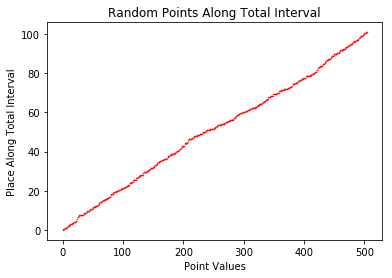

The maximum difference between random points is  1.32781122391
The number of empty intervals is  5


In [4]:
P.plot(ptVec, 'ro', markersize=0.5)
P.title("Random Points Along Total Interval")
P.xlabel("Point Values")
P.ylabel("Place Along Total Interval")
P.show()

DiffSort = U.sort(U.diff(ptVec))
maxDiff = U.ndarray.max(DiffSort)
print("The maximum difference between random points is ",maxDiff)

zeroCount = DiffSort > 1  #find entries in DiffSort that are greater than 1
zeroCountList = zeroCount.tolist()
print("The number of empty intervals is ",zeroCountList.count(True))